# Outlook

In this notebook we explain how the reward is indexed in BBRL, and we show that the two options present in the literature are available.

## The SaLinA data storage model

Before covering the above issues, let us first see how [the official SaLinA library from facebook](https://github.com/facebookresearch/salina) stores data into a workspace.

In the standard RL literature, the environment is in some state $s_t$, then the agent performs an action $a_t$. As a result, the environment moves to state $s_{t+1}$. But for the reward, there are two possible notations:
- either we consider that the agent receives reward $r_t$, resulting in $<s_t, a_t, r_t, s_{t+1}>$ samples, as is common in many papers. This is the notation used in my class.
- or we consider that the agent receives reward $r_{t+1}$, resulting in $<s_t, a_t, r_{t+1}, s_{t+1}>$ samples. This is the choice of Sutton and Barto's textbook, see [footnote 3 page 54 of the 2018 edition](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf#page=68). Actually, this second option makes more sense, it is unclear why the environment would emit reward $r_t$ but state $s_{t+1}$ after action $a_t$. But even Sutton and Barto are ambiguous about these notations as the often write $p(s',r|s,a)$ where one could expect $p(s',r'|s,a)$.

The coexistence of these two notations in the literature is infortunate as different libraries may make different choices. It is more practical in SaLinA to implement the second option. Hence the official SaLinA repository uses $<s_t, a_t, r_{t+1}, s_{t+1}>$ samples. 

In BBRL, we have made both options available. If users prefer the first option (using $<s_t, a_t, r_t, s_{t+1}>$), they should import GymAgent classes from `bbrl.agent.gymb`. Otherwise, sticking to the SaLinA option, they must import GymAgent classes from `bbrl.agent.gyma`. Besides, when using other reward related RL functionalities such as computing a temporal difference error or a Generalized Advantage Estimate, they should import `bbrl.rl.functionalb` if they use the first option and `bbrl.rl.functionalb` if they use the SaLinA reward indexing scheme.

Another point is that, whatever the index of the reward, the state information in a sequence contains one more element than the reward (and action) information: from $s_0$ to $s_{t+1}$ versus from $r_0$ to $r_t$ or from $r_1$ to $r_{t+1}$, which results in a data alignment issue.

#### Data collection with the SaLinA convention

With the SaLinA convention, when the environment is reset in state $s_0$, there is no corresponding reward thus an artificial reward $r=0$ is stored, resolving the data alignment issue. This model is illustrated in the figure below.

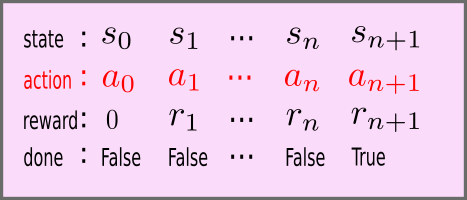

In SaLinA, the interaction informations written and red by agents is organized into time frames that we call `steps` and note $step_i = < s_i, a_i, done_i, truncated_i, ...>$ with more or less step variables stored depending on the algorithm.

But note that these frames are written both by the agent (in red) and the environment (in black) in a specific order. The environment writes the state and the reward, then the agent writes the action corresponding to the state. 
With the reward indexing choice of SaLinA, this ordering raises no specific issue.

Thus this model is easier to code and data from the environment is easily aligned when an epoch stops.

#### Data collection with the other convention

Implementing the alternative model is more involved. This model is illustrated in the figure below.

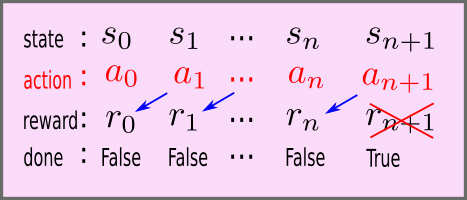

As previously, the initial state $s_0$ is obtained by calling the `reset()` function, then the agent chooses action $a_0$ from the state, then the reward is determined. But this time, the reward should be written in the same time frame as the state, when the action and next state are known. The correct way to do this while filling the reward sequence with as many elements as the state sequence is the following. At any time step but the first, the environment copies the state and the reward into the frame of the current time step, but it also copies the reward into the frame of the previous time step.

#### Writing the Temporal difference update (Bellman backup)

As a result of this approach, the last reward of the data collected during an epoch should be ignored, as illustrated in the figure above.

The function that performs data collection and thus performs the copy of the reward at $t$ and $t-1$ is [the forward function in the GymAgent class in the gymb.py file](https://github.com/osigaud/bbrl/blob/master/bbrl/agents/gymb.py#L245-L272), by contrast with [the version in the gyma.py file](https://github.com/osigaud/bbrl/blob/master/bbrl/agents/gyma.py#L224-L251). 

As a consequence of the above choice, when using the SaLinA version, performing a Bellman backup with the value function $V(s)$ writes:

In [ ]:
target = reward[1:] + discount_factor * critic[1:].detach() * (must_bootstrap.float())
td = target - critic[:-1]


that is, we take all the rewards after the first time step (`reward[1:]`),

whereas when using the other reward indexing function, it writes:

In [ ]:
target = reward[:-1] + discount_factor * critic[1:].detach() * (must_bootstrap.float())
td = target - critic[:-1]

that is, we take all the rewards from the first time steps, but the last which should be ignored (`reward[:-1]`).

In all the colabs used to teach RL with BBRL, we stick to our convention, using $r_t$ rather than $r_{t+1}$.